In [397]:
import astropy.units as u
from astropy.time import Time
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
import tqdm
import string
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import time_support
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
from collections import defaultdict
from matplotlib.patches import Rectangle
import pandas as pd

In [105]:
targets = {
    'HAT-P-11': 1, 
    'K2-121': 1,
    'K2-136': 3,
    'WASP-43': 1,
    'WASP-107': 1,
    'GJ 9827': 3,
    'K2-266': 4,
    'K2-3': 3,
    'Kepler-138': 3,
    'AU Mic': 1,
    'GJ 357': 1,
    'GJ 3470': 1,
    'K2-18': 1,
    'GJ 436': 1,
    'L 98-59': 3,
    'K2-33':1 ,
    'LTT 1445 A': 1,
    'K2-25': 1,
    'LHS 3844': 1,
    'TRAPPIST 1': 7,
}
transit_times = {}
obs_transit_times = {}
anti_solar = {}
porb = {}

In [106]:
for star in tqdm.tqdm(targets):
    for pletter in string.ascii_lowercase[1:targets[star]+1]:
        planet_properties = NasaExoplanetArchive.query_planet(f"{star} {pletter}", all_columns=True)

        # get relevant planet properties
        epoch = Time(planet_properties['pl_tranmid'], format='jd')
        period = planet_properties['pl_orbper']
        transit_duration = planet_properties['pl_trandur'] 
        porb[f"{star} {pletter}"] = period
        # Create an EclipsingSystem object for HD 209458
        from astroplan import EclipsingSystem
        planet = EclipsingSystem(primary_eclipse_time=epoch, orbital_period=period,
                                     duration=transit_duration)

        # Calculate next three mid-transit times which occur after ``obs_time``
        obs_time = Time('2025-01-01 00:00')
        n_eclipses = 365.25 * u.day / period + 1
        planet.next_primary_eclipse_time(obs_time, n_eclipses=n_eclipses)

        transit_times[f"{star} {pletter}"] =  planet.next_primary_eclipse_time(obs_time, n_eclipses=n_eclipses)
        
        ast = ((Time('2025-03-21 00:00') +
                   (planet_properties["st_elon"] /(360*u.deg)) *
                   365.25 * u.day) - (3*365.25) * u.day)
        while ast < Time('2025-1-1 00:00'):
                ast += 365.25 * u.day
        anti_solar[f"{star} {pletter}"] = ast

  0%|          | 0/20 [00:00<?, ?it/s]WARNING: AstropyDeprecationWarning: The query_planet function is deprecated and may be removed in a future version.
        Use query_object instead. [warnings]
100%|██████████| 20/20 [02:52<00:00,  8.60s/it]


In [107]:

# march 21 is approximately ecliptic longitude zero at antisolar
# so let's check for when a planet is +/- 30 ecliptic long of antisolar


In [108]:
anti_solar

{'HAT-P-11 b': <Time object: scale='utc' format='iso' value=['2025-02-09 23:41:39.258']>,
 'K2-121 b': <Time object: scale='utc' format='iso' value=['2025-07-25 18:52:28.097']>,
 'K2-136 b': <Time object: scale='utc' format='iso' value=['2025-05-30 06:46:48.766']>,
 'K2-136 c': <Time object: scale='utc' format='iso' value=['2025-05-30 06:46:48.766']>,
 'K2-136 d': <Time object: scale='utc' format='iso' value=['2025-05-30 06:46:48.766']>,
 'WASP-43 b': <Time object: scale='utc' format='iso' value=['2025-08-30 20:41:41.103']>,
 'WASP-107 b': <Time object: scale='utc' format='iso' value=['2025-10-01 12:04:18.236']>,
 'GJ 9827 b': <Time object: scale='utc' format='iso' value=['2025-03-12 19:34:55.081']>,
 'GJ 9827 c': <Time object: scale='utc' format='iso' value=['2025-03-12 19:34:55.081']>,
 'GJ 9827 d': <Time object: scale='utc' format='iso' value=['2025-03-12 19:34:55.081']>,
 'K2-266 b': <Time object: scale='utc' format='iso' value=['2025-08-29 13:40:44.441']>,
 'K2-266 c': <Time objec

100%|██████████| 39/39 [00:08<00:00,  4.44it/s]


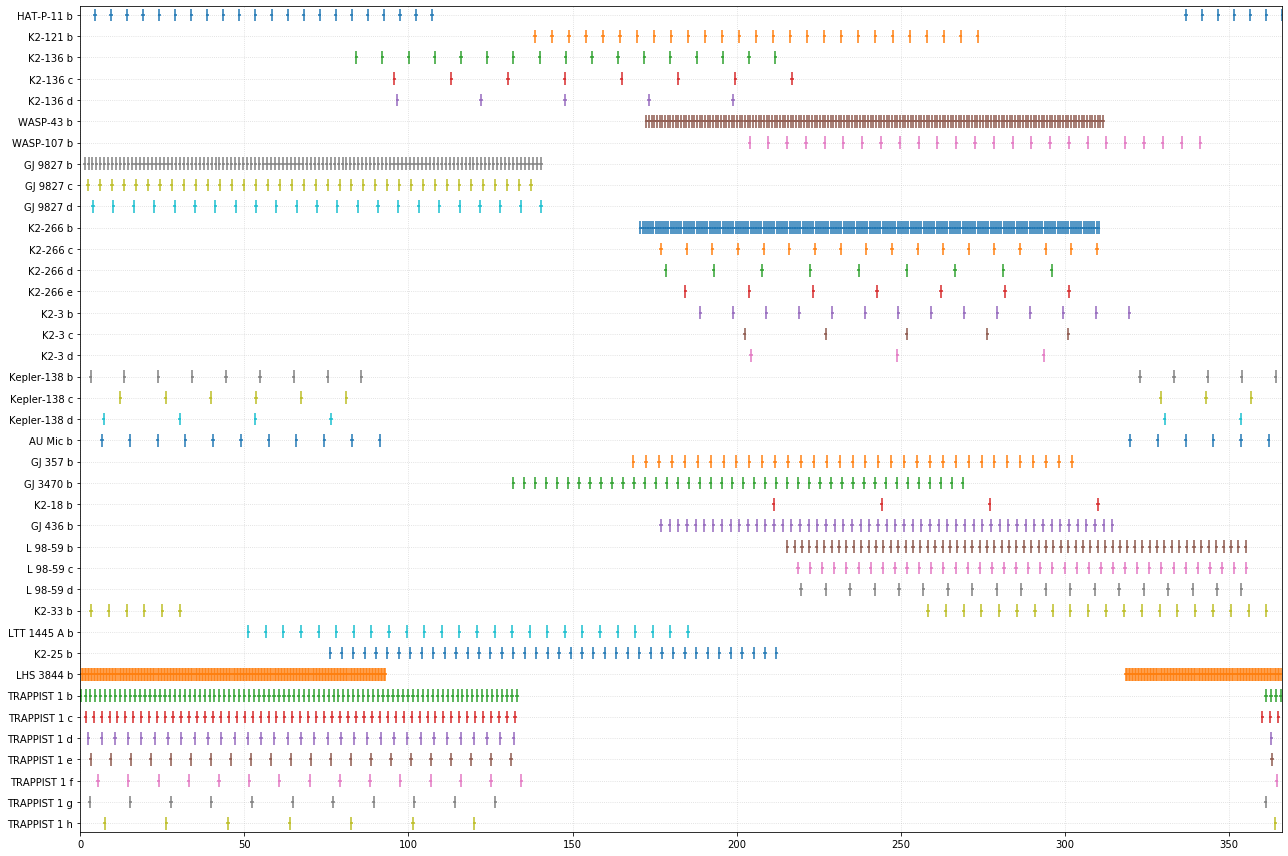

In [401]:
i = len(transit_times)-1
window = 70
# with time_support():
yticklabels = []
fig, ax = plt.subplots(1, 1, figsize=[18, 12])
for tt in tqdm.tqdm(transit_times):
    ntransits = len(transit_times[tt])
    mask = np.ones(ntransits, dtype=bool)
    for j, ttime in enumerate(transit_times[tt]):
        if (((ttime >= anti_solar[tt] - window) and (ttime <= anti_solar[tt] + window)) or
            ((ttime >= anti_solar[tt] - window - 365.25) and (ttime <= anti_solar[tt] + window - 365.25)) or 
            ((ttime >= anti_solar[tt] - window + 365.25) and (ttime <= anti_solar[tt] + window + 365.25))):
            mask[j] = True
        else:
            mask[j] = False
    tx = (transit_times[tt][mask] - Time('2025-01-01 00:00')).jd
    obs_transit_times[tt] = [x for x in tx if (x >0) and (x < 365.25)]
    ax.errorbar(tx, np.repeat(i, len(tx)), xerr=0.5,
            yerr=0.3,
            ls="",
            marker="")
    yticklabels.append(tt)
    i -= 1
ax.set(yticks=np.arange(len(transit_times)), yticklabels=yticklabels[::-1])
ax.set_xlim(0, 366)
ax.grid(ls=":", alpha=0.5)
# ax.set_xlim(0, 60)
ax.set_ylim(-0.4, len(transit_times)-1+0.4)

plt.tight_layout()

plt.savefig("mock_observing calendar.png", dpi=200)

In [402]:
porb_sorted = sorted(porb.items(), key=lambda x: x[1], reverse=True)

In [403]:
minutes_in_a_year = int(365.25 * (86400/60))
minutes_12_hours = int(60 * 12)


In [426]:
scheduled_transit = {}
open_times = np.ones(minutes_in_a_year, dtype=bool)
for planet, _ in porb_sorted:
    scheduled_transit[planet] = []
    for tt in obs_transit_times[planet][::-1]:
        tt_minutes = int(tt * 1440)
        for offset in range(4*60, -4*60, -10):
            if (np.alltrue(open_times[tt_minutes - minutes_12_hours + offset:tt_minutes + minutes_12_hours + offset])
                and 
               (len(scheduled_transit[planet]) < 10)):
                open_times[tt_minutes - minutes_12_hours + offset:tt_minutes + minutes_12_hours + offset] = False
                scheduled_transit[planet].append(tt + (offset/1440.))
                break
        
        
            
            

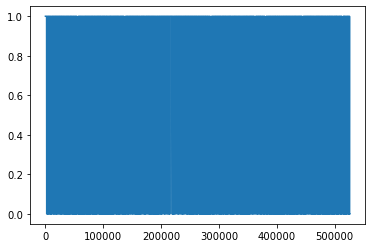

In [427]:
plt.plot(open_times)

In [428]:
[len(scheduled_transit[x]) for x in scheduled_transit]

[3,
 4,
 5,
 5,
 6,
 5,
 7,
 6,
 7,
 7,
 8,
 9,
 10,
 10,
 8,
 10,
 9,
 10,
 10,
 5,
 9,
 9,
 10,
 8,
 6,
 5,
 4,
 10,
 5,
 10,
 6,
 5,
 6,
 5,
 5,
 2,
 10,
 3,
 10]

100%|██████████| 39/39 [00:00<00:00, 208.40it/s]


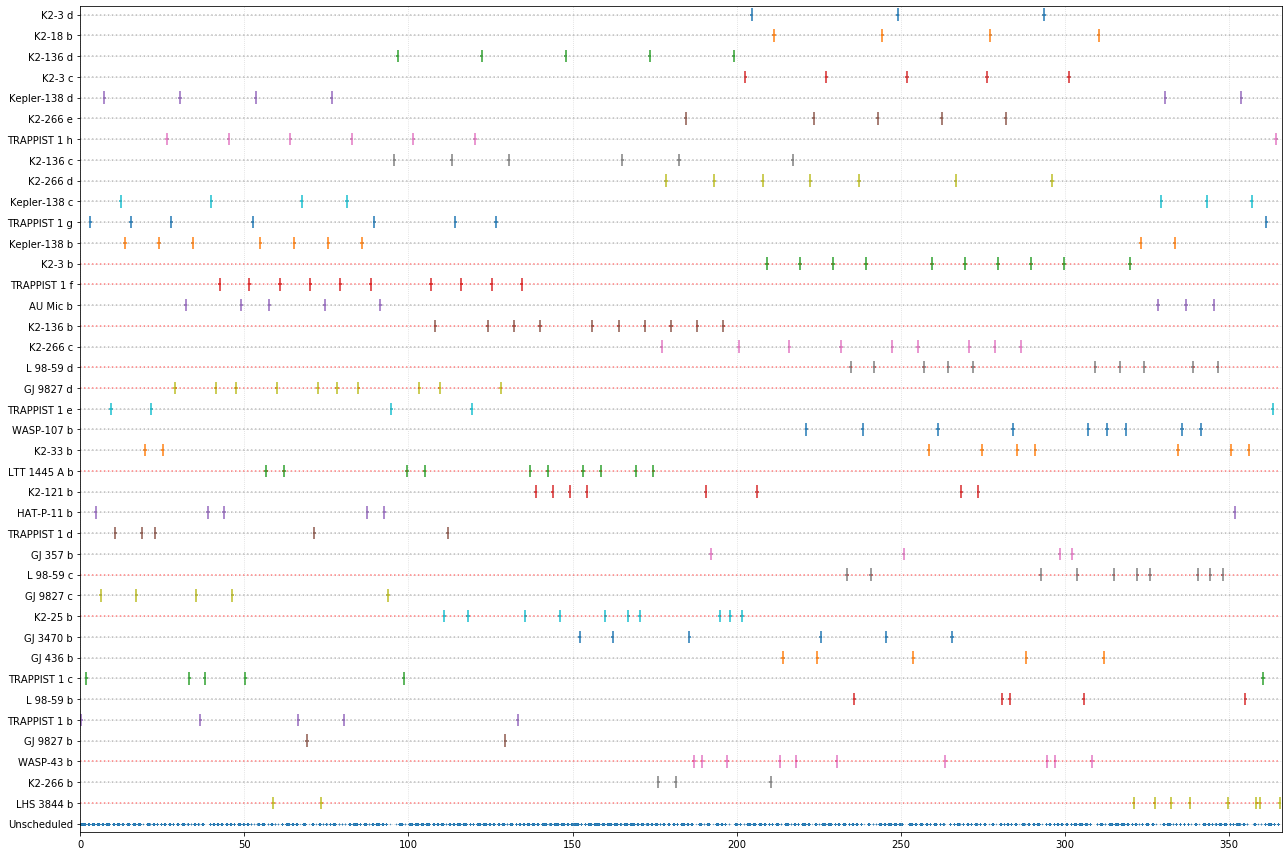

In [429]:
i = len(scheduled_transit)-1
yticklabels = []
fig, ax = plt.subplots(1, 1, figsize=[18, 12])
for planet in tqdm.tqdm(scheduled_transit):
    ntransits = len(scheduled_transit[planet])
    ax.errorbar(scheduled_transit[planet], np.repeat(i, ntransits), xerr=0.5,
            yerr=0.3,
            ls="",
            marker="")
    yticklabels.append(planet)
    if ntransits >= 10:
        ax.hlines(i, 0, 365.25, color='r', ls=':', alpha=0.5)
    else:
        ax.hlines(i, 0, 365.25, color='grey', ls=':', alpha=0.5)
    i -= 1
ax.scatter(np.where(open_times,np.arange(minutes_in_a_year)/1440, np.nan),
         np.repeat(-1, len(open_times)), s=0.1)
yticklabels.append("Unscheduled")
ax.set(yticks=np.arange(-1, len(scheduled_transit)), yticklabels=yticklabels[::-1])
ax.set_xlim(0, 366)
ax.grid(ls=":", alpha=0.5, which="both")
# ax.set_xlim(0, 30)
ax.set_ylim(-1.4, len(scheduled_transit)-1+0.4)

plt.tight_layout()

plt.savefig("mock_year_in_the_life_v1.png", dpi=200)

In [336]:
[print(yticklabels[i], list(scheduled_transit.keys())[i]) for i in range(40)]

K2-3 d K2-3 d
K2-18 b K2-18 b
K2-136 d K2-136 d
K2-3 c K2-3 c
Kepler-138 d Kepler-138 d
K2-266 e K2-266 e
TRAPPIST 1 h TRAPPIST 1 h
K2-136 c K2-136 c
K2-266 d K2-266 d
Kepler-138 c Kepler-138 c
TRAPPIST 1 g TRAPPIST 1 g
Kepler-138 b Kepler-138 b
K2-3 b K2-3 b
TRAPPIST 1 f TRAPPIST 1 f
AU Mic b AU Mic b
K2-136 b K2-136 b
K2-266 c K2-266 c
L 98-59 d L 98-59 d
GJ 9827 d GJ 9827 d
TRAPPIST 1 e TRAPPIST 1 e
WASP-107 b WASP-107 b
K2-33 b K2-33 b
LTT 1445 A b LTT 1445 A b
K2-121 b K2-121 b
HAT-P-11 b HAT-P-11 b
TRAPPIST 1 d TRAPPIST 1 d
GJ 357 b GJ 357 b
L 98-59 c L 98-59 c
GJ 9827 c GJ 9827 c
K2-25 b K2-25 b
GJ 3470 b GJ 3470 b
GJ 436 b GJ 436 b
TRAPPIST 1 c TRAPPIST 1 c
L 98-59 b L 98-59 b
TRAPPIST 1 b TRAPPIST 1 b
GJ 9827 b GJ 9827 b
WASP-43 b WASP-43 b
K2-266 b K2-266 b
LHS 3844 b LHS 3844 b


IndexError: list index out of range

In [337]:
yticklabels[i]

'Unscheduled'

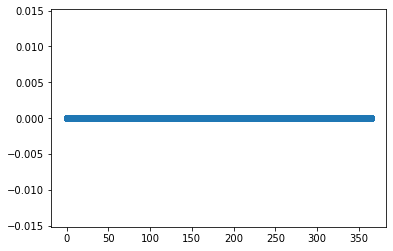

In [290]:
plt.scatter(np.where(open_times,np.arange(minutes_in_a_year)/1440, np.nan),
         np.repeat(0, len(open_times)))

In [284]:
np.repeat(0, len(open_times))

array([0, 0, 0, ..., 0, 0, 0])

In [288]:
np.where(open_times,np.arange(minutes_in_a_year)/1440, np.nan)

array([0.        , 0.00069444, 0.00138889, ...,        nan,        nan,
              nan])

In [286]:
open_times

array([ True,  True,  True, ..., False, False, False])

KeyError: 0